# ML Analysis
Will attempt to do some sort of clustering.
## Set up Environment

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn import tree

In [4]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

In [5]:
os.listdir(path + 'cleaned')

['.DS_Store',
 'BX-Books.csv',
 'BX-Ratings.csv',
 'BX-Users.csv',
 'BX-NewBooksRatings.csv',
 '.ipynb_checkpoints']

## Pull in required data:

In [6]:
books = pd.read_csv(path + 'cleaned/BX-Books.csv')
users = pd.read_csv(path + 'cleaned/BX-Users.csv')
ratings = pd.read_csv(path + 'cleaned/BX-Ratings.csv')

In [7]:
books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector
0,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.]


In [8]:
users.head(1)

,Unnamed: 0,User-ID,User-City,User-State,User-Country,User-Age,Age-Group
0,0,8,timmins,ontario,canada,44.0,1


In [9]:
ratings.head(1)

,User-ID,ISBN,Book-Rating
0,276744,038550120X,7


### TF-IDF for Book Info:

In [10]:
tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english')

In [11]:
tfidf_matrix = tf.fit(books['Book-Info'])

In [12]:
book_vector = tfidf_matrix.transform(books['Book-Info']).toarray()

In [13]:
books['Book-Vector'] = list(book_vector)

### Discretize ratings, year of published ...

array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

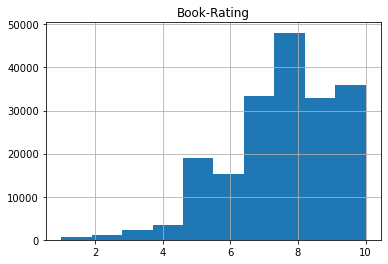

In [256]:
# ratings are skewed towards higher
# users are more likely to leave a nice review
ratings.hist('Book-Rating')

In [15]:
from sklearn.preprocessing import KBinsDiscretizer

In [16]:
encoder = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

In [17]:
ratings_discretized = encoder.fit_transform(ratings[['Book-Rating']])

In [18]:
encoder.bin_edges_

array([array([ 1.        ,  3.62727768,  5.76263836,  7.790488  , 10.        ])],
      dtype=object)

In [19]:
ratings['Rating-Group'] = ratings_discretized.astype(int)

In [20]:
ratings['Rating-Group'].unique()

array([2, 3, 1, 0])

In [21]:
ratings

,User-ID,ISBN,Book-Rating,Rating-Group
0,276744,038550120X,7,2
1,276754,0684867621,8,3
2,276755,0451166892,5,1
3,276762,0380711524,5,1
4,276772,0553572369,7,2
...,...,...,...,...
204159,276688,0892966548,10,3
204160,276688,1551669315,6,2
204161,276704,0345386108,6,2
204162,276704,0743211383,7,2


In [177]:
ratings = ratings.merge(users)

In [178]:
weighted_ratings = ratings.groupby(['ISBN', 'User-Country', 'Age-Group']).agg(average_rating 
                                     = ('Book-Rating', 'mean'), times_read = ('User-ID', 'count'), average_age = ('User-Age', 'mean')) \
                                    .reset_index()

In [257]:
m = 5
# weighted_ratings = weighted_ratings[weighted_ratings['times_read'] > m]
weighted_ratings

,ISBN,User-Country,Age-Group,average_rating,times_read,average_age,weighted_ratings
0,0002005018,canada,0,7.333333,3,25.666667,7.431000
1,0002005018,canada,1,7.666667,3,39.666667,7.681000
2,0002005018,canada,2,7.000000,1,60.000000,7.362001
3,0002116286,canada,0,8.000000,1,24.000000,7.862001
4,0002116286,canada,1,7.000000,2,32.000000,7.241334
...,...,...,...,...,...,...,...
68539,9728423160,portugal,1,6.000000,1,36.000000,6.862001
68540,9812327975,united kingdom,0,8.000000,1,28.000000,7.862001
68541,9871138148,portugal,1,9.000000,1,41.000000,8.362001
68542,9871138148,spain,0,8.000000,2,20.000000,7.908000


In [258]:
t = weighted_ratings['times_read']
a = weighted_ratings['average_rating']
c = ratings['Book-Rating'].mean()

In [259]:
weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))

In [260]:
weighted_ratings.sort_values('weighted_ratings', ascending = False)

,ISBN,User-Country,Age-Group,average_rating,times_read,average_age,weighted_ratings
27158,0439139597,usa,0,9.522388,67,22.283582,9.397500
13035,0345339738,usa,0,9.475000,40,23.325000,9.280445
27127,0439136350,usa,0,9.370968,62,21.903226,9.248060
23447,039480001X,usa,0,9.909091,11,21.181818,9.226250
27159,0439139597,usa,1,9.395349,43,39.372093,9.221250
...,...,...,...,...,...,...,...
62298,0971880107,united kingdom,2,2.166667,6,52.500000,4.692728
62296,0971880107,united kingdom,0,3.307692,13,22.538462,4.534445
62302,0971880107,usa,2,4.253333,75,56.906667,4.470250
62252,0971880107,australia,1,3.526316,19,37.947368,4.400834


In [261]:
weighted_ratings['weighted_ratings'].describe()

count    68544.000000
mean         7.714013
std          0.368112
min          4.304445
25%          7.510910
50%          7.770001
75%          7.945715
max          9.397500
Name: weighted_ratings, dtype: float64

array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

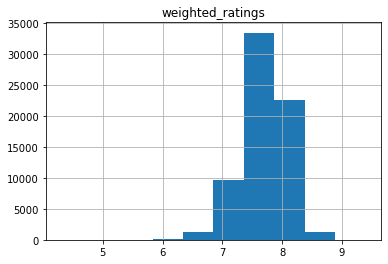

In [262]:
weighted_ratings.hist('weighted_ratings')

## Look into popularity metric:

In [263]:
books_ratings = books.merge(weighted_ratings)

In [264]:
## find good split here...
books_ratings.sort_values('weighted_ratings', ascending = False).head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector,User-Country,Age-Group,average_rating,times_read,average_age,weighted_ratings
13865,0439139597,harry potter goblet fire book 4,j k rowling,2000.0,scholastic,harry potter goblet fire book 4 by j k rowling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",usa,0,9.522388,67,22.283582,9.3975


In [265]:
books_ratings = books.merge(weighted_ratings)

In [216]:
encoder = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

In [217]:
average_ratings_discretized = encoder.fit_transform(books_ratings[['average_rating']])
weight_ratings_discretized = encoder.fit_transform(books_ratings[['weighted_ratings']])

In [218]:
encoder.bin_edges_

array([array([2.96057163, 4.65217875, 6.34378587, 8.035393  , 9.72700012])],
      dtype=object)

In [219]:
books_ratings['Average-Rating-Group'] = average_ratings_discretized.astype(int)
books_ratings['Weighted-Rating-Group'] = weight_ratings_discretized.astype(int)

In [220]:
decade_list = [1919 + 10 * x for x in range(10)]

In [221]:
books_ratings['Year-Of-Publication-Group'] = pd.cut(x=books_ratings['Year-Of-Publication'], bins=decade_list)

In [222]:
books_ratings.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector,User-Country,Age-Group,average_rating,times_read,average_age,weighted_ratings,Average-Rating-Group,Weighted-Rating-Group,Year-Of-Publication-Group
0,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,clara callan by richard bruce wright,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",canada,0,7.333333,3,25.666667,7.431,2,2,"(1999, 2009]"


In [223]:
books_ratings.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Book-Publisher', 'Book-Info', 'Book-Vector', 'User-Country',
       'Age-Group', 'average_rating', 'times_read', 'average_age',
       'weighted_ratings', 'Average-Rating-Group', 'Weighted-Rating-Group',
       'Year-Of-Publication-Group'],
      dtype='object')

In [224]:
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(books_ratings[['User-Country']])
books_ratings[['User-Country']] = encoded.astype(int)

In [225]:
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(books_ratings[['Year-Of-Publication-Group']])
books_ratings[['Year-Of-Publication-Group']] = encoded.astype(int)

In [226]:
X = books_ratings[['Book-Info', 'User-Country', 'Age-Group', 'Year-Of-Publication-Group']]
y = books_ratings['Weighted-Rating-Group']

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [228]:
X_train.head(1)

,Book-Info,User-Country,Age-Group,Year-Of-Publication-Group
16799,name by jose saramago,111,2,8


In [229]:
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer())
])


# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', 'passthrough', ['Age-Group', 'Year-Of-Publication-Group']),
    ('country', 'passthrough', ['User-Country'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'Book-Info'),
                                                 ('group', 'passthrough',
                                                  ['Age-Group',
                                                   'Year-Of-Publication-Group']),
                                                 ('country', 'passthrough',
                                                  ['User-Country'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [230]:
y_pred = pipeline.predict(X_test)

In [231]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred_train = pipeline.predict(X_train)

# Display classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       155
           1       0.92      1.00      0.96      2695
           2       0.97      0.99      0.98     33133
           3       1.00      0.94      0.97     18852

    accuracy                           0.98     54835
   macro avg       0.96      0.98      0.97     54835
weighted avg       0.98      0.98      0.98     54835

Confusion Matrix (Training Set):
[[  155     0     0     0]
 [    2  2688     2     3]
 [    4   171 32920    38]
 [    2    68   978 17804]]


In [232]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix_train)

Accuracy: 0.554526223648698
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.09      0.10      0.09        31
           1       0.09      0.08      0.09       630
           2       0.64      0.68      0.66      8331
           3       0.44      0.39      0.41      4717

    accuracy                           0.55     13709
   macro avg       0.31      0.31      0.31     13709
weighted avg       0.54      0.55      0.55     13709

Confusion Matrix (Test Set):
[[   3    2   18    8]
 [   2   52  436  140]
 [  20  367 5701 2243]
 [  10  140 2721 1846]]


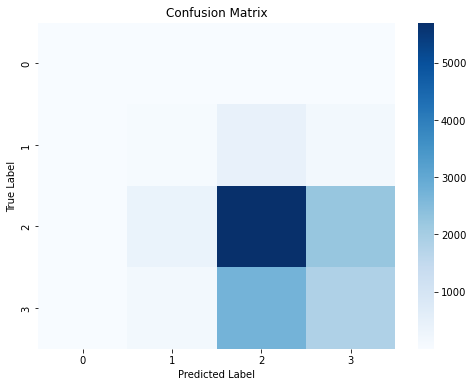

In [233]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='%d', cmap='Blues',
            xticklabels=['0', '1', '2', '3'],
            yticklabels=['0', '1', '2', '3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [234]:
cm

array([[   3,    2,   18,    8],
       [   2,   52,  436,  140],
       [  20,  367, 5701, 2243],
       [  10,  140, 2721, 1846]])

In [235]:
X

,Book-Info,User-Country,Age-Group,Year-Of-Publication-Group
0,clara callan by richard bruce wright,17,0,8
1,clara callan by richard bruce wright,17,1,8
2,clara callan by richard bruce wright,17,2,8
3,flu story great influenza pandemic 1918 search...,111,0,7
4,flu story great influenza pandemic 1918 search...,111,1,7
...,...,...,...,...
68539,ice house tv tie edition by minette walters,104,2,7
68540,trouble business vintage crime black lizard by...,17,0,7
68541,trouble business vintage crime black lizard by...,111,0,7
68542,trouble business vintage crime black lizard by...,111,1,7


In [252]:
example_dict = {'Book-Info':'harry potter by jk rowling',
                          'User-Country':17, 'Age-Group':2, 'Year-Of-Publication-Group':9}
example_dict

{'Book-Info': 'harry potter by jk rowling',
 'User-Country': 17,
 'Age-Group': 2,
 'Year-Of-Publication-Group': 9}

In [253]:
X_example = pd.DataFrame(example_dict, index = [0])

In [254]:
X_example

,Book-Info,User-Country,Age-Group,Year-Of-Publication-Group
0,harry potter by jk rowling,17,2,9


In [255]:
pipeline.predict(X_example)

array([2])